## Fastmarch

In [1]:
import numpy as np
from crowd_sim.envs.policy.orca import ORCA
from crowd_sim.envs.utils.state import JointState
import CMap2D
import matplotlib.pyplot as plt
from map2d import gridshow
from navrep.envs.e2eenv import E2ENavRepEnvPretrain #, E2ENavRepEnv

from stable_baselines import PPO2
from stable_baselines.gail import ExpertDataset
from navrep.tools.custom_policy import CustomPolicy, Custom1DPolicy, ARCH, _C

rng = np.random.default_rng()

class Suicide(object):
    def __init__(self):
        pass

class FastmarchORCAPolicy(object):
    def __init__(self, suicide_if_stuck=False):
        self.simulator = ORCA()
        self.suicide_if_stuck = suicide_if_stuck
        self.map = CMap2D.CMap2D()
        self.grid_num = 100
        self.new = True

    def reset(self):
        self.new = True
        self.simulator.reset()        
    
    def predict(self, obs, env):
        self.simulator.time_step = env._get_dt()
        other_agent_states = [
            agent.get_observable_state() for agent in env.soadrl_sim.humans + env.soadrl_sim.other_robots]
        joint_state = JointState(env.soadrl_sim.robot.get_full_state(), other_agent_states)
        
        if self.new:
            #find an appropriate origin
            bbox = env.soadrl_sim.obstacle_vertices[-1]
            bbox_ll = np.array(bbox[-1])
            bbox_tr = np.array(bbox[1])
            self.map.origin[0] = bbox_ll[0] - 0.25
            self.map.origin[1] = bbox_ll[1] - 0.25
            
            #find the right resolution
            max_dim = max(bbox_tr-bbox_ll)
            #offset = 2*max_dim/self.grid_num
            self.map.set_resolution((max_dim+2*0.25)/self.grid_num)
            
            #initialise occupancy
            self.map._occupancy = np.ones((self.grid_num,self.grid_num), dtype = np.float32)
            bbox_ij = self.map.xy_to_ij(bbox)
            self.map._occupancy[bbox_ij[-1,0]:bbox_ij[1,0], bbox_ij[-1,1]:bbox_ij[1,1]] = 0
            
            radius = env.soadrl_sim.robot.radius*1.05
            for vertex in env.soadrl_sim.obstacle_vertices[:-1]:
                xy_min, xy_max = np.min(vertex, 0), np.max(vertex,0)
                xy_min -= radius
                xy_max += radius
                min_max_ij = self.map.xy_to_ij([xy_min,xy_max])
                self.map._occupancy[min_max_ij[0,0]:min_max_ij[1,0], min_max_ij[0,1]:min_max_ij[1,1]] = 1
            #self.map.HUGE_ = 100 * np.prod( self.map._occupancy.shape )
            #calculate the field
            goal = self.map.xy_to_ij([(env.soadrl_sim.robot.gx,env.soadrl_sim.robot.gy)])
            self.field = self.map.fastmarch(goal[0])
            
            self.new = False
        
            # only for vizualisation atm
            robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
            robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
            gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8)
        robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
        robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
        gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8) 
        
        if gridfmpath8.shape[0] > 15:
            virtual_goal = gridfmpath8[15]  # look forward in path
            virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
            virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
            joint_state.self_state.gx = virtual_goal[0]
            joint_state.self_state.gy = virtual_goal[1]
            
            if np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2) < 0.25:
                virtual_goal = gridfmpath8[8]  # look forward in path
                virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
                virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
                idx = np.argmin([virtual_goal[0] - robot_pos_xy[0],virtual_goal[0] - robot_pos_xy[0]])
                if idx == 0:
                    joint_state.self_state.gx = robot_pos_xy[0] + np.sign(virtual_goal[0] - robot_pos_xy[0])#*(virtual_goal[1] - robot_pos_xy[1]) #virtual_goal[0]
                elif idx == 1:
                    joint_state.self_state.gy = robot_pos_xy[1] + np.sign(virtual_goal[1] - robot_pos_xy[1])#*(virtual_goal[0] - robot_pos_xy[0]) #virtual_goal[1]
            
        action = self.simulator.predict(
            joint_state,
            env.soadrl_sim.obstacle_vertices,
            env.soadrl_sim.robot,
        )
        if self.suicide_if_stuck:
            if action.v < 0.02:
                return Suicide()
        vx = action.v * np.cos(action.r)
        vy = action.v * np.sin(action.r)
        return np.array([vx, vy]+0.01*rng.standard_normal(2))

/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib

Ros was not found, disabled.


## Expert data generation

In [2]:
import os
import warnings
from typing import Dict

import cv2  # pytype:disable=import-error
import numpy as np
from gym import spaces


#currently the episode length is not used
def alt_generate_expert_traj(env, n_episodes, episode_length=1000,render=True,
                         policy=FastmarchORCAPolicy(),save_path=None):
    actions = []
    observations = []
    rewards = []
    episode_returns = np.zeros((n_episodes,))
    episode_starts = []

    ep_idx = 0
    policy.reset()
    obs = env.reset()
    print(obs.shape)
    episode_starts.append(True)
    reward_sum = 0.0
    idx = 0
    while ep_idx < n_episodes:
        observations.append(obs)
        action = policy.predict(obs, env)
        if isinstance(action, Suicide):
            rew = 0
            action = np.array([0, 0, 0])
            done = True
        else:
            obs, reward, done, _ = env.step(action)
        
        actions.append(action)
        rewards.append(reward)
        episode_starts.append(done)
        reward_sum += reward
        if render:
            env.render()
        if done:
            obs = env.reset()
            policy.reset()
            episode_returns[ep_idx] = reward_sum
            reward_sum = 0.0
            ep_idx += 1
    
    if isinstance(env.observation_space, spaces.Box):
        observations = np.concatenate(observations).reshape((-1,) + env.observation_space.shape)
        
    if isinstance(env.action_space, spaces.Box):
        actions = np.concatenate(actions).reshape((-1,) + env.action_space.shape)
        
    rewards = np.array(rewards)
    episode_starts = np.array(episode_starts[:-1])

    assert len(observations) == len(actions)
    
    numpy_dict = {
        'actions': actions,
        'obs': observations,
        'rewards': rewards,
        'episode_returns': episode_returns,
        'episode_starts': episode_starts
    }  # type: Dict[str, np.ndarray]

    for key, val in numpy_dict.items():
        print(key, val.shape)

    if save_path is not None:
        np.savez(save_path, **numpy_dict)

    env.close()

    return numpy_dict

In [3]:
expert_data_name = 'fmORCA_humans'
env = E2ENavRepEnvPretrain(silent=True, scenario='test', adaptive=False, collect_statistics=False)
env.soadrl_sim.human_num = 3
env.soadrl_sim.num_walls = 5
env.soadrl_sim.num_circles = 0

In [4]:
data_reg = alt_generate_expert_traj(env,150,policy=FastmarchORCAPolicy(), save_path = expert_data_name, render=False)

(4101,)
actions (15191, 2)
obs (15191, 4101)
rewards (15191,)
episode_returns (150,)
episode_starts (15191,)


## Load data, create model and plot untrained outputs

In [5]:
expert_data = np.load(expert_data_name+".npz")
actions = expert_data['actions'][:1000]
observations = expert_data['obs'][:1000]
model = PPO2(CustomPolicy, env, verbose=1)
action, _ = model.predict(observations, deterministic=True)

Wrapping the env in a DummyVecEnv.
Instructions for updating:
Use keras.layers.conv2d instead.


Instructions for updating:
Use keras.layers.conv2d instead.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


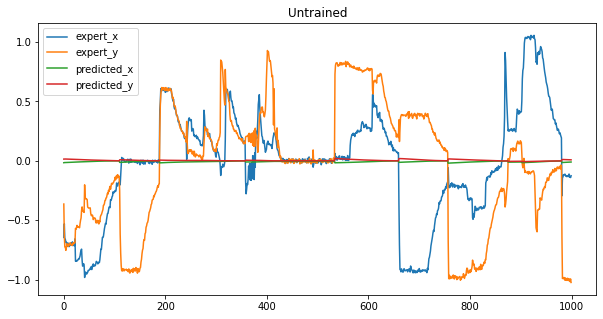

In [6]:
fig, ax1 = plt.subplots(figsize=[10,5])
plt.plot(actions[:,0], label="expert_x")
plt.plot(actions[:,1], label="expert_y")
plt.plot(action[:,0],label="predicted_x")
plt.plot(action[:,1],label="predicted_y")
plt.title("Untrained")
plt.legend()
plt.show()

## Pretrain model

In [7]:
dataset = ExpertDataset(expert_path=expert_data_name+".npz",traj_limitation=1, batch_size=64)
model.pretrain(dataset, n_epochs=300)

actions (15191, 2)
obs (15191, 4101)
rewards (15191,)
episode_returns (150,)
episode_starts (15191,)
Total trajectories: 1
Total transitions: 187
Average returns: 73.62662853968435
Std for returns: 47.79395366580538
Pretraining with Behavior Cloning...
==== Training progress 10.00% ====
Epoch 30
Training loss: 0.085277, Validation loss: 0.078196

==== Training progress 20.00% ====
Epoch 60
Training loss: 0.031139, Validation loss: 0.038356

==== Training progress 30.00% ====
Epoch 90
Training loss: 0.008904, Validation loss: 0.007856

==== Training progress 40.00% ====
Epoch 120
Training loss: 0.002233, Validation loss: 0.003173

==== Training progress 50.00% ====
Epoch 150
Training loss: 0.003516, Validation loss: 0.004747

==== Training progress 60.00% ====
Epoch 180
Training loss: 0.001242, Validation loss: 0.001885

==== Training progress 70.00% ====
Epoch 210
Training loss: 0.001110, Validation loss: 0.001759

==== Training progress 80.00% ====
Epoch 240
Training loss: 0.004134, V

In [8]:
action, _ = model.predict(observations[0:3000], deterministic=True)

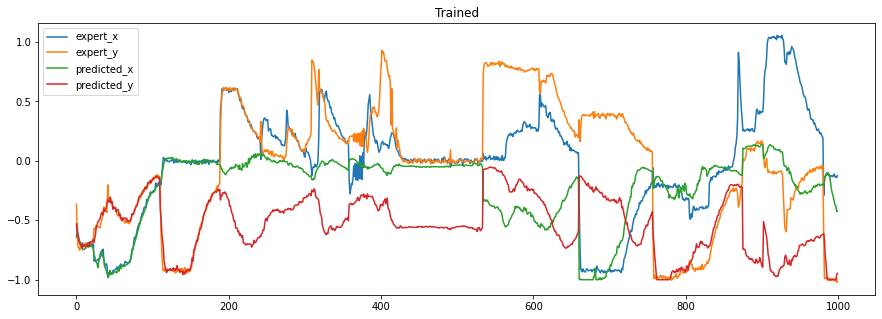

In [9]:
fig, ax1 = plt.subplots(figsize=[15,5])
plt.plot(actions[:,0], label="expert_x")
plt.plot(actions[:,1], label="expert_y")
plt.plot(action[:,0],label="predicted_x")
plt.plot(action[:,1],label="predicted_y")
plt.title("Trained")
plt.legend()
plt.show()

In [10]:
env = model.get_env()

In [12]:
obs = env.reset()
reward_sum = 0.0
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    reward_sum += reward
    env.render()
    if done:
        print(reward_sum)
        reward_sum = 0.0
        obs = env.reset()

[-34.100334]
[-25.064072]
[-24.553404]
[-35.951546]
[-23.508802]
[-27.071821]
[-24.371048]
[-25.02642]
[-25.290274]
[-26.999542]
[-25.741005]
[-27.78944]
[-28.598581]
[-24.770517]
[-25.063]
[-25.979069]
[-25.57858]
